# Import Libraries & Dataset
This section imports all necessary libraries for data manipulation, visualization, and modeling.
It also loads the dataset and displays basic information to understand its structure.


In [1]:
# Import Libraries and Load Data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc


# Defining my class helpers
class LoadData:
  @staticmethod
  def Load_data(path):
    data = pd.read_csv(path)
    return data

class DataCleaningHelpers:
  @staticmethod
  def get_zeroes(df, col):
    return (df[col] == 0).sum()

  @staticmethod
  def get_blankspaces(df, col):
    return (df[col].str.strip() == '').sum()

  @staticmethod
  def get_empty_string_zeroes(df):
    for column in df.columns:
      if df[column].dtype == 'object':
        col_zeroes = DataCleaningHelpers.get_blankspaces(df, column)
        if col_zeroes != 0:
          print(f'Empty strings - {column}: {col_zeroes}')
      else:
        print(f'Number of zeroes - {column}: {DataCleaningHelpers.get_zeroes(df, column)}')

class DataVisualization:
  @staticmethod
  def countplot(df, column):
      plt.figure(figsize=(15, 5))
      ax = sns.countplot(x=column, data=df, hue="Churn", palette="Set2")
      for value in ax.patches:
          if value.get_height() > 0:  # Skip bars with height 0
              percentage = "{:.1f}%".format(100 * value.get_height() / len(df))
              x = value.get_x() + value.get_width() / 2 - 0.05
              y = value.get_y() + value.get_height()
              ax.annotate(percentage, (x, y), fontweight="black", size=15)
      plt.title(f"Customer Churned by {column}", fontweight="black", size=20, pad=20)
      plt.show()

  @staticmethod
  def distribution(df, column):
    plt.figure(figsize=(10, 5))
    sns.displot(data=df, x=column, hue="Churn", palette="Set2", kde=True)
    plt.title(f"Distribution of {column}", fontweight="black", size=20, pad=20)
    plt.show()

class LabelEncoderHelper:
  @staticmethod
  def label_encode(df):
    le = LabelEncoder()
    for column in df.columns:
      if df[column].dtype == 'object':
        df[column] = le.fit_transform(df[column])
    return df

class StandardScalerHelper:
  @staticmethod
  def scale(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    return X_scaled, y

class DataProcessing:
  def __init__(self, model):
    self.models = model

  def KFold_cross_validation(self, X, y, cv=5):
    model_name = None
    model_results = []
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    for model_name, model in self.models.items():
      kfold_accuracy = []
      confusion_matrix_list = []
      for train_index, train_test in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[train_test]
        y_train, y_test = y.iloc[train_index], y.iloc[train_test]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        kfold_accuracy.append(accuracy)
        confusion_matrix_list.append(confusion_matrix(y_test, y_pred))

      kfold_accuracy_avg = np.mean(kfold_accuracy)
      confusion_matrix_list_avg = np.mean(confusion_matrix_list, axis=0).astype(int)

      model_results.append({
          'Model Name': model_name,
          'Accuracy': kfold_accuracy_avg,
          'Confusion Matrix': confusion_matrix_list_avg
      })

    return model_results

class StackingModel:
  def __init__(self, base_models, meta_model):
      self.base_models = base_models
      self.meta_model = meta_model

  def generate_meta_features(self, X, y=None, kfold=5):
    X = np.array(X)
    if y is not None:
        y = np.array(y)
    meta_features = np.zeros((X.shape[0], len(self.base_models)))
    if y is not None:  # For training data
        kf = KFold(n_splits=kfold, shuffle=True, random_state=42)
        for i, (name, model) in enumerate(self.base_models.items()):
            fold_predictions = np.zeros((X.shape[0],))
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                model.fit(X_train, y_train)
                fold_predictions[val_index] = model.predict(X_val)
            meta_features[:, i] = fold_predictions
    else:  # For test data
        for i, (name, model) in enumerate(self.base_models.items()):
            meta_features[:, i] = model.predict(X)

    return meta_features

  def stack(self, X_train, y_train, X_test):
      meta_train = self.generate_meta_features(X_train, y_train)
      self.meta_model.fit(meta_train, y_train)

      meta_test = self.generate_meta_features(X_test)
      meta_predictions = self.meta_model.predict(meta_test)
      return meta_predictions


df = LoadData.Load_data('churn_data.csv')
df.info() # no null data



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Data Cleaning
This section ensures data quality by handling missing or empty values, converting non-numeric columns to numeric
where necessary, and dropping rows with insufficient data.


In [2]:
# Data Cleaning
print(df.shape) # 7043(rows) x 21(columns)
DataCleaningHelpers.get_empty_string_zeroes(df)

(7043, 21)
Number of zeroes - SeniorCitizen: 5901
Number of zeroes - tenure: 11
Number of zeroes - MonthlyCharges: 0
Empty strings - TotalCharges: 11


In [3]:
# Dropping empty rows
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
DataCleaningHelpers.get_empty_string_zeroes(df)

print(df.shape)

Number of zeroes - SeniorCitizen: 5890
Number of zeroes - tenure: 0
Number of zeroes - MonthlyCharges: 0
Number of zeroes - TotalCharges: 0
(7032, 21)


# Exploratory Data Analysis (EDA)
In this section, we visualize the distribution of the target variable (Churn), explore relationships
between features, and analyze insights derived from the dataset.


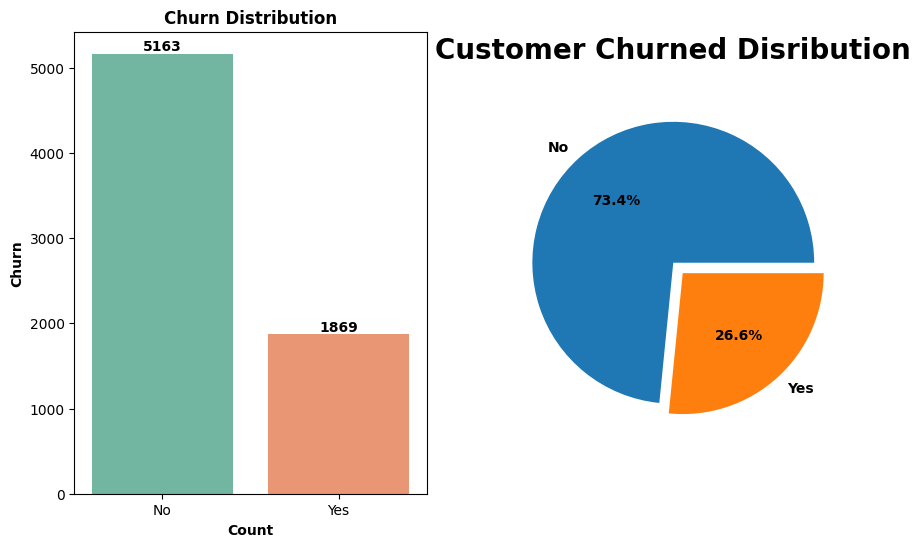

In [4]:
# Data visualizations
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
ax=sns.countplot(data = df, x='Churn', palette="Set2")
ax.bar_label(ax.containers[0], fontweight='bold')
ax.bar_label(ax.containers[1], fontweight='bold')
plt.title('Churn Distribution', fontweight='bold')
plt.xlabel('Count', fontweight='bold')
plt.ylabel('Churn', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(df['Churn'].value_counts().values, labels=df['Churn'].value_counts().index, autopct="%1.1f%%",colors=sns.set_palette("Set2"),
        textprops={"fontweight":"black"},explode=[0,0.1])
plt.title("Customer Churned Disribution",fontweight="black",size=20,pad=20)
plt.show()

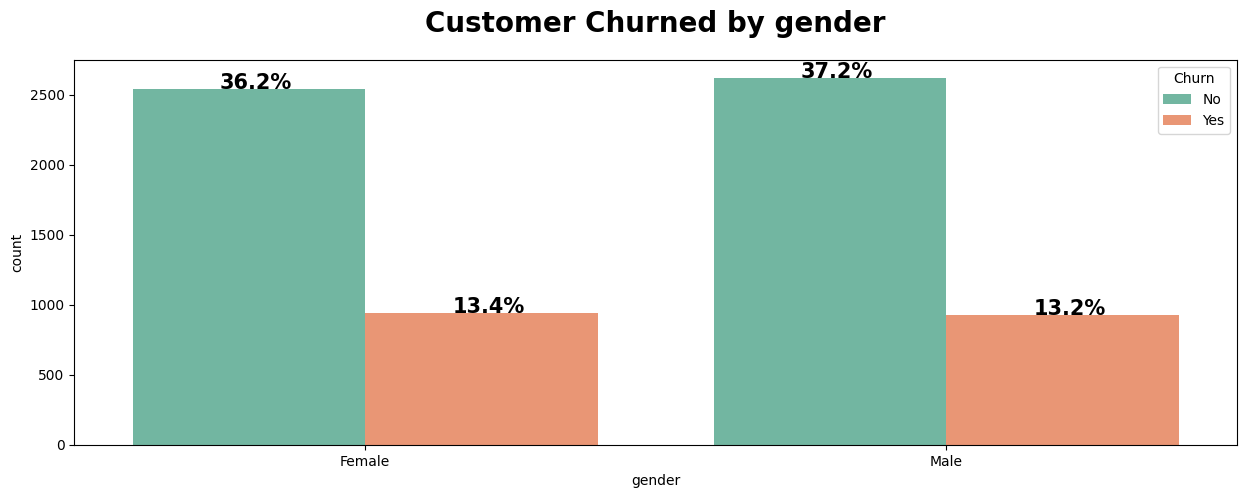

In [5]:
# Gender
DataVisualization.countplot(df, 'gender')

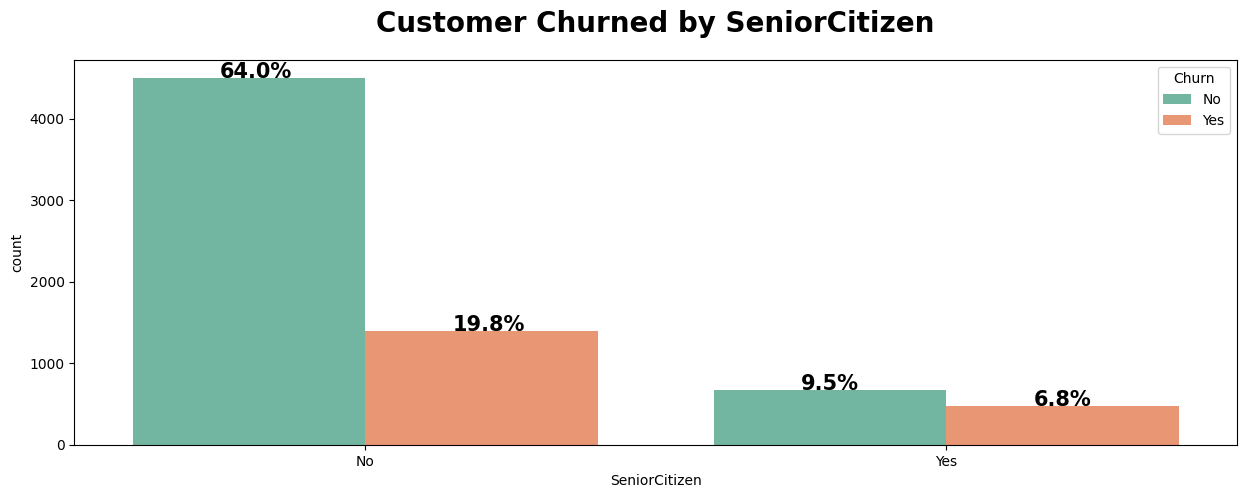

In [6]:
# SeniorCitizen
df_senior_citizen = df.copy()
df_senior_citizen['SeniorCitizen'] = df_senior_citizen['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
DataVisualization.countplot(df_senior_citizen, 'SeniorCitizen')

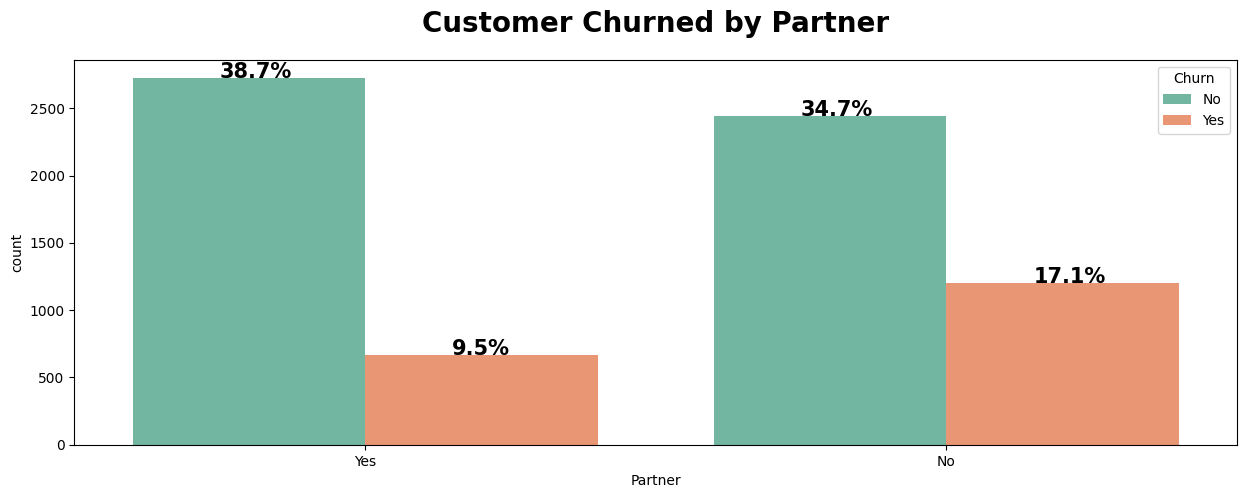

In [7]:
# Partner
DataVisualization.countplot(df, 'Partner')

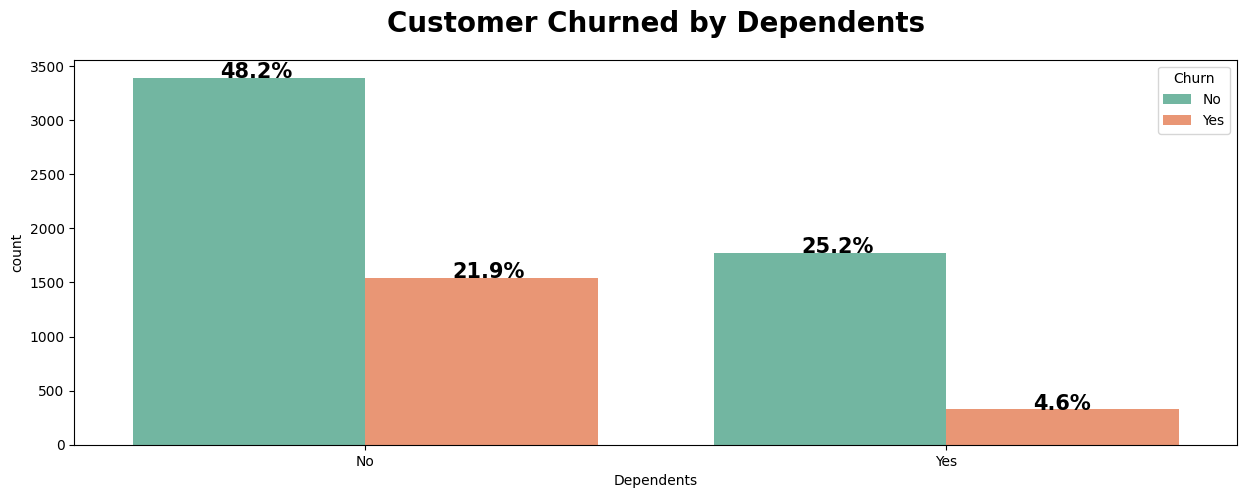

In [8]:
# Dependents
DataVisualization.countplot(df, 'Dependents')

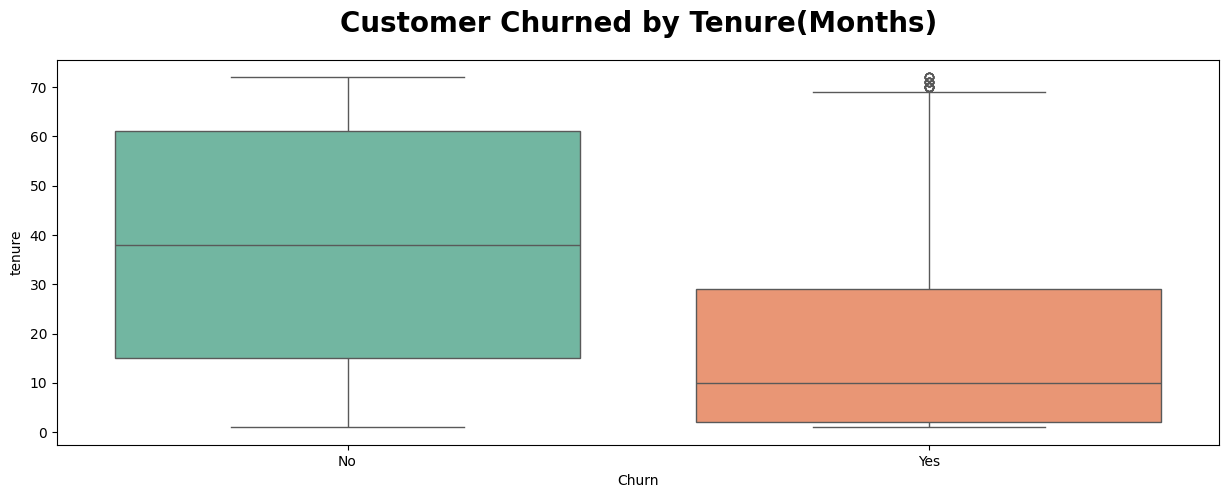

In [9]:
# tenure
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='Churn', y='tenure', palette="Set2")
plt.title('Customer Churned by Tenure(Months)', fontweight='black', size=20, pad=20)
plt.show()

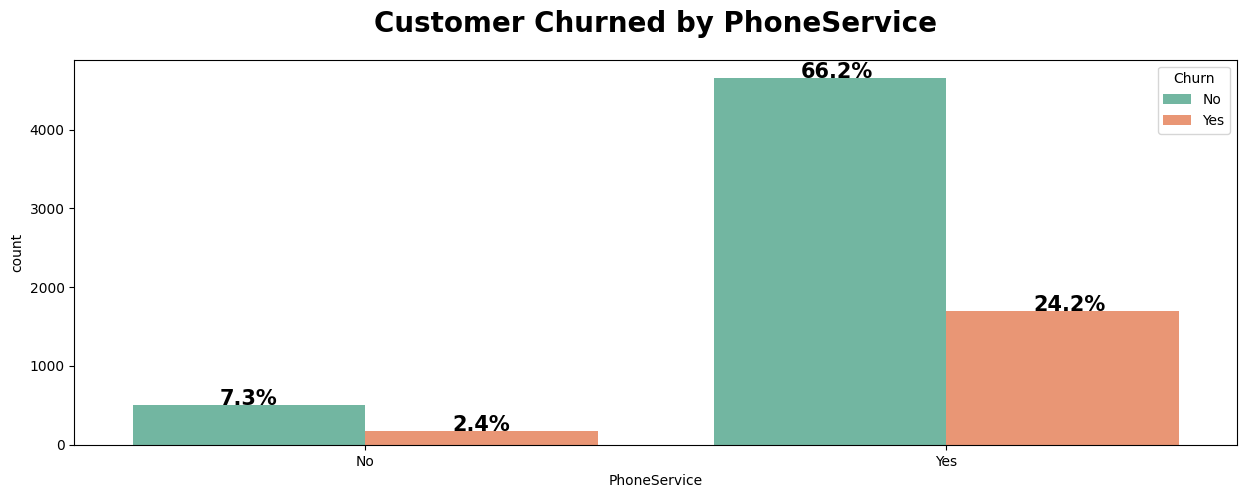

In [10]:
# PhoneService
DataVisualization.countplot(df, 'PhoneService')

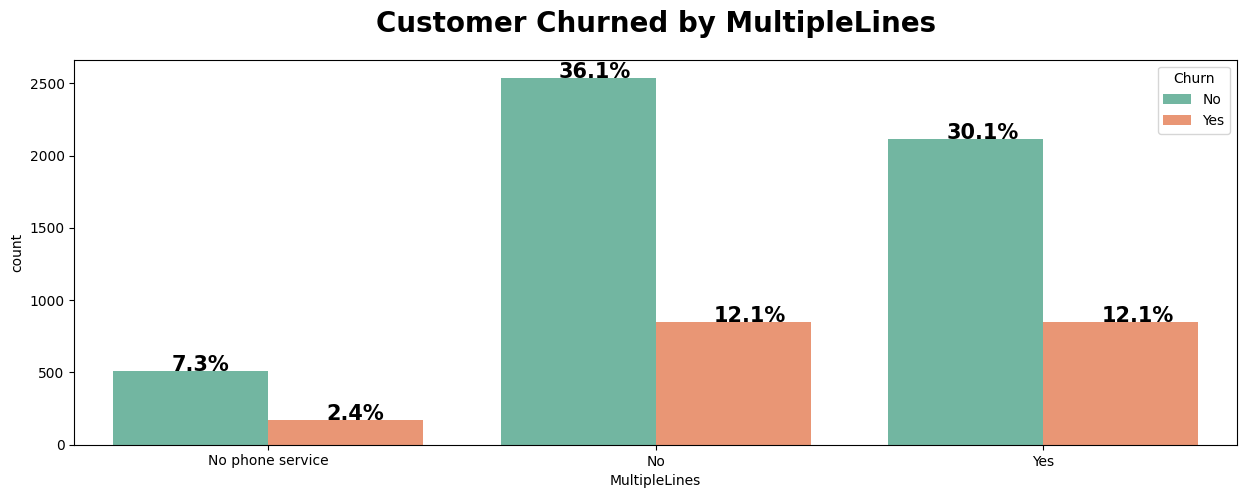

In [11]:
# MultipleLines
DataVisualization.countplot(df, 'MultipleLines')

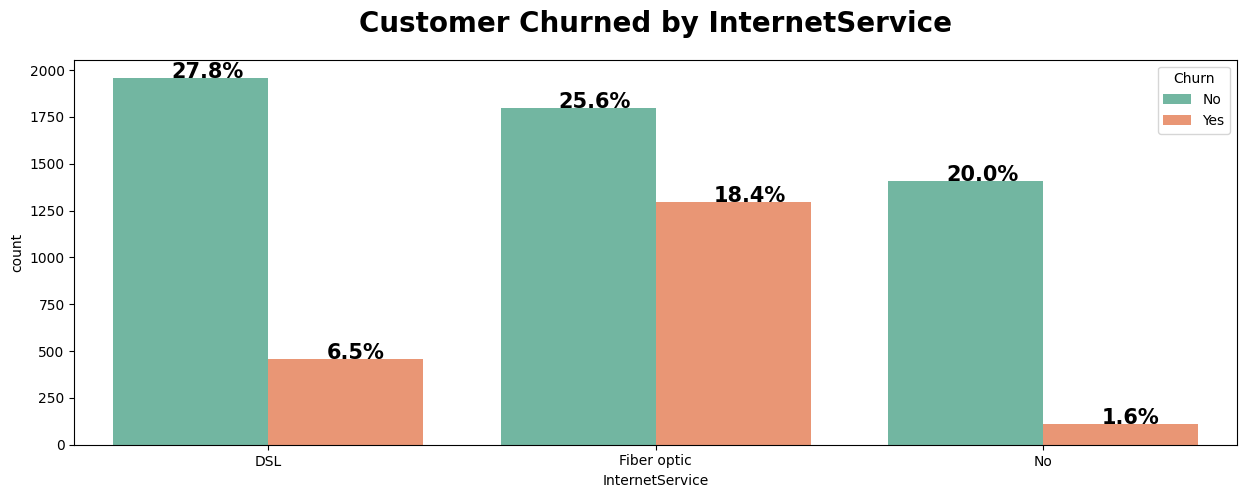

In [12]:
# InternetService
DataVisualization.countplot(df, 'InternetService')

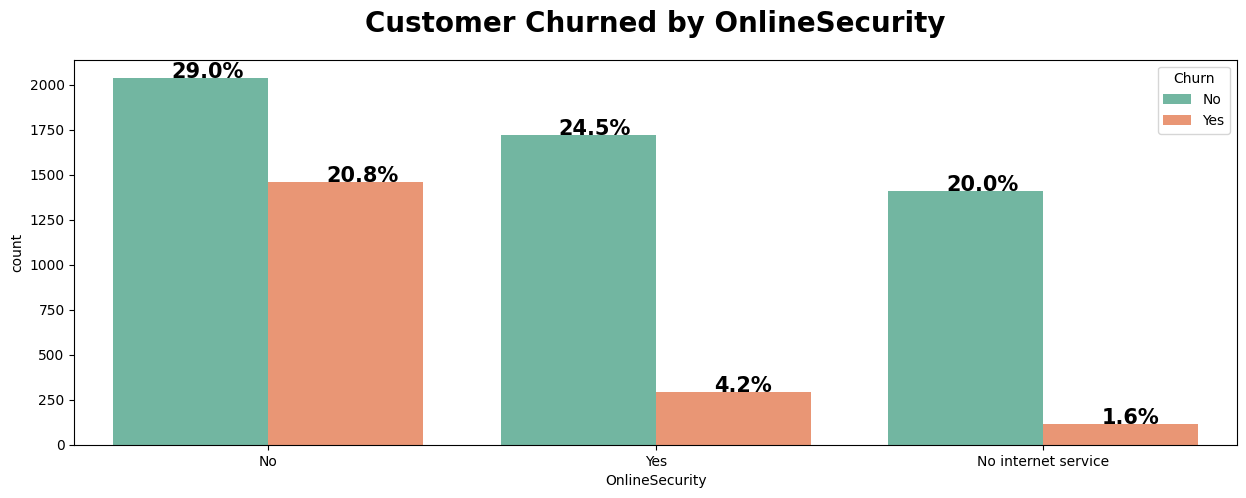

In [13]:
# OnlineSecurity
DataVisualization.countplot(df, 'OnlineSecurity')

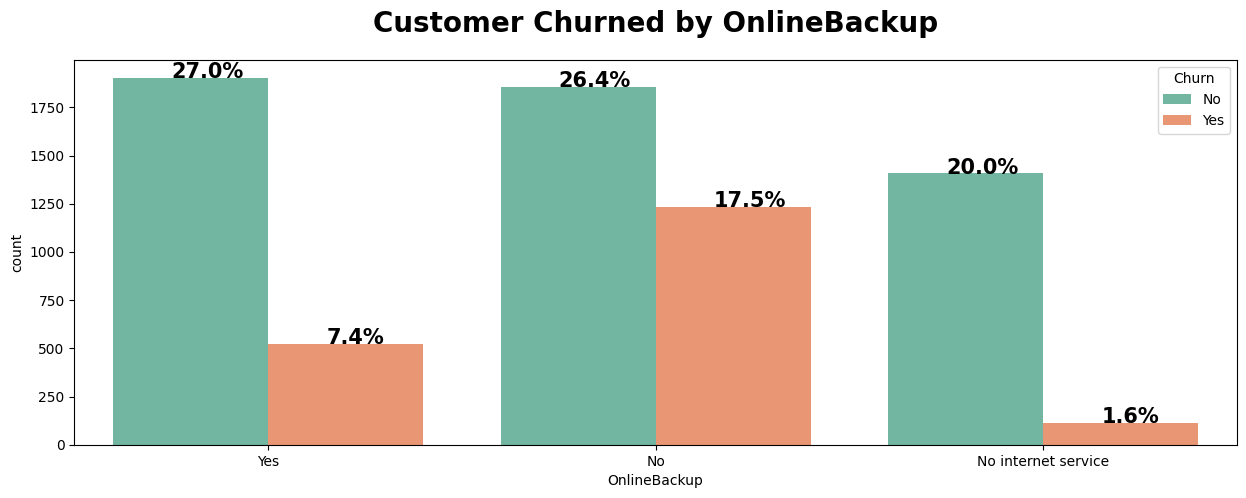

In [14]:
# OnlineBackup
DataVisualization.countplot(df, 'OnlineBackup')

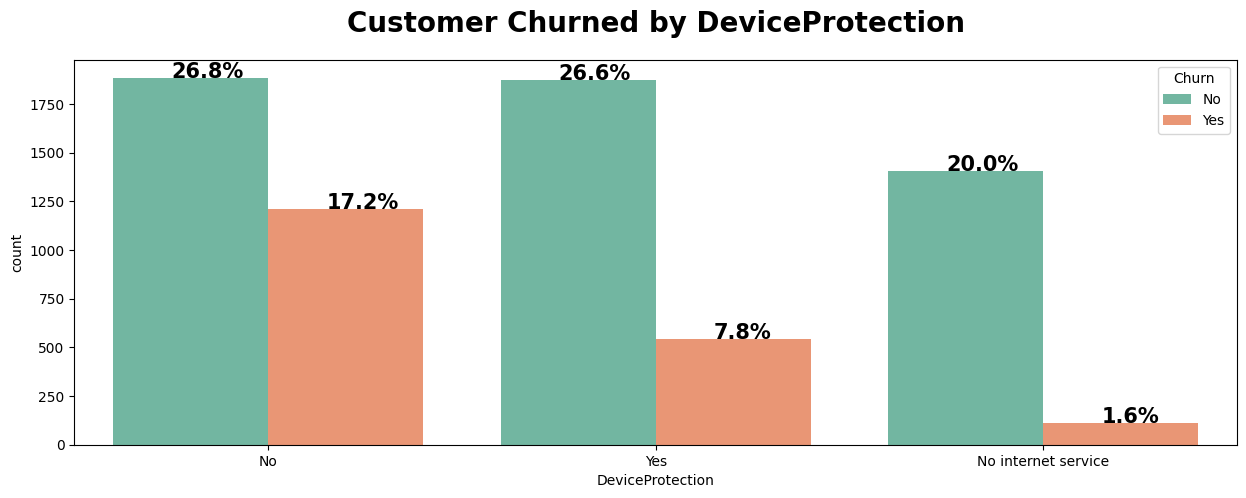

In [15]:
# DeviceProtection
DataVisualization.countplot(df, 'DeviceProtection')

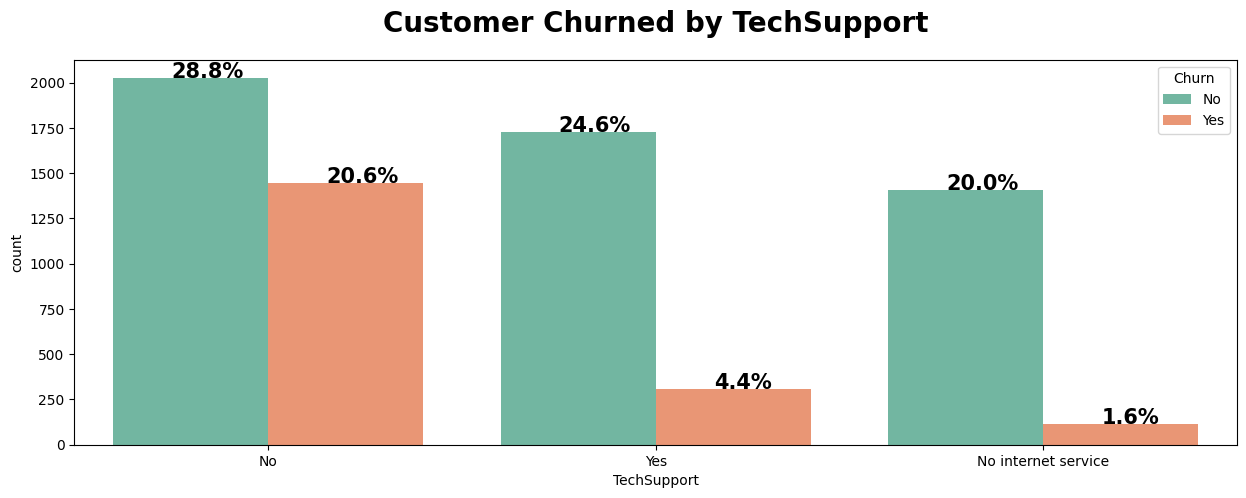

In [16]:
# TechSupport
DataVisualization.countplot(df, 'TechSupport')

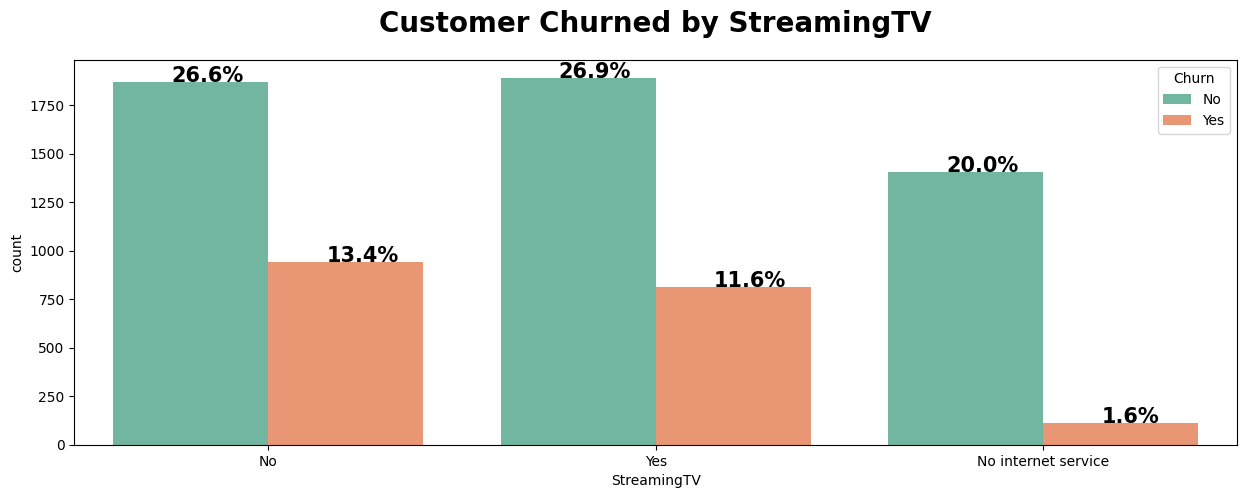

In [17]:
# StreamingTV
DataVisualization.countplot(df, 'StreamingTV')

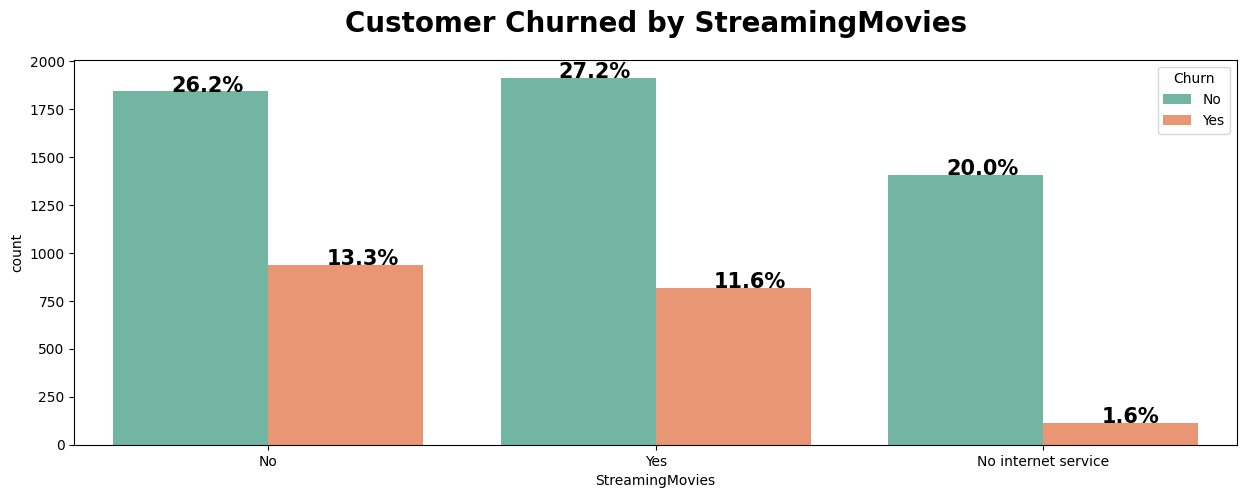

In [18]:
# StreamingMovies
DataVisualization.countplot(df, 'StreamingMovies')

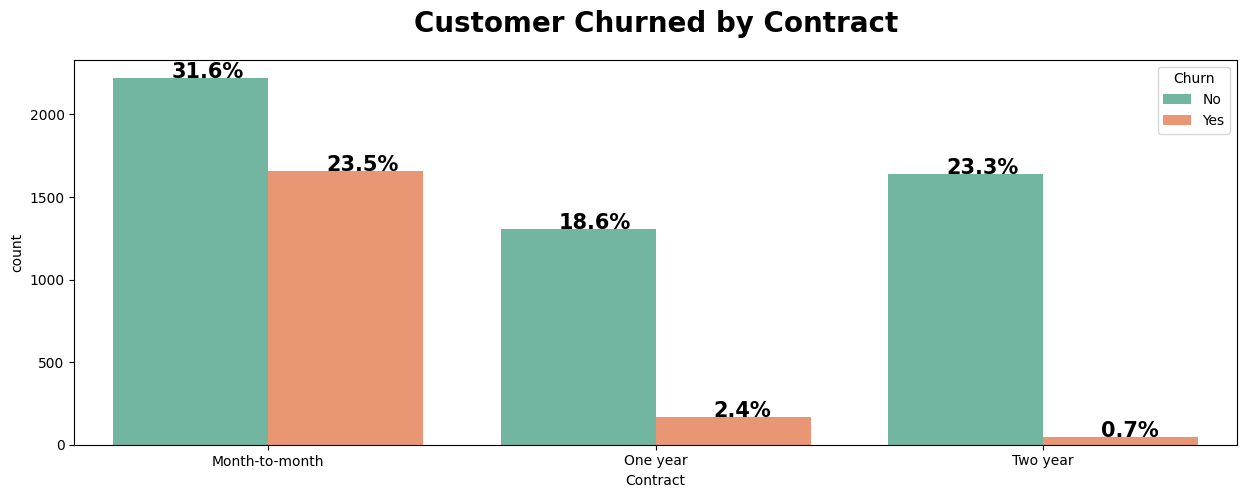

In [19]:
# Contract
DataVisualization.countplot(df, 'Contract')

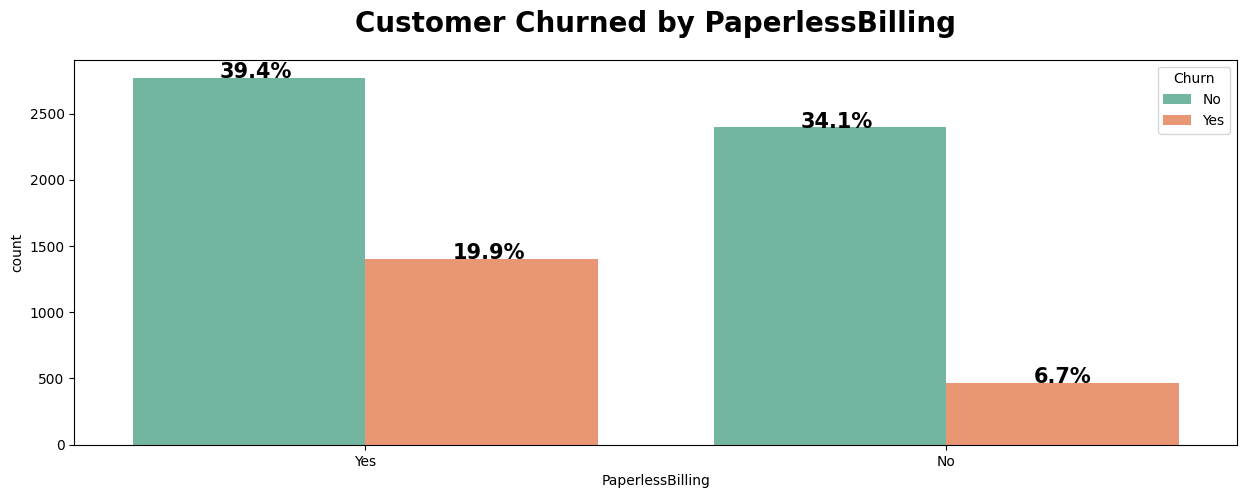

In [20]:
# PaperlessBilling
DataVisualization.countplot(df, 'PaperlessBilling')

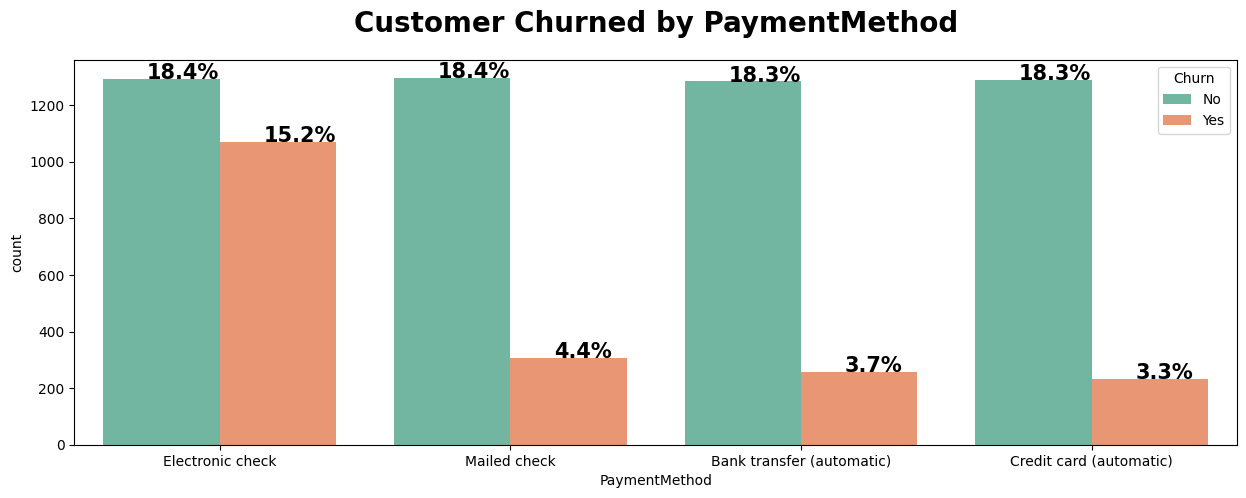

In [21]:
# PaymentMethod
DataVisualization.countplot(df, 'PaymentMethod')

<Figure size 1000x500 with 0 Axes>

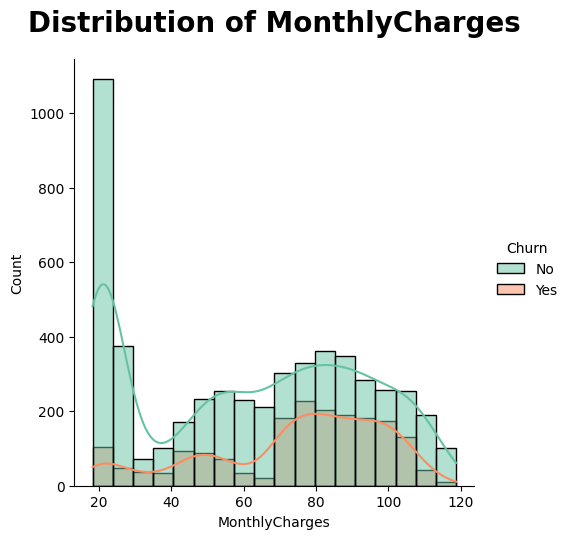

In [22]:
# Distribution of MonthlyCharges
DataVisualization.distribution(df, 'MonthlyCharges')

<Figure size 1000x500 with 0 Axes>

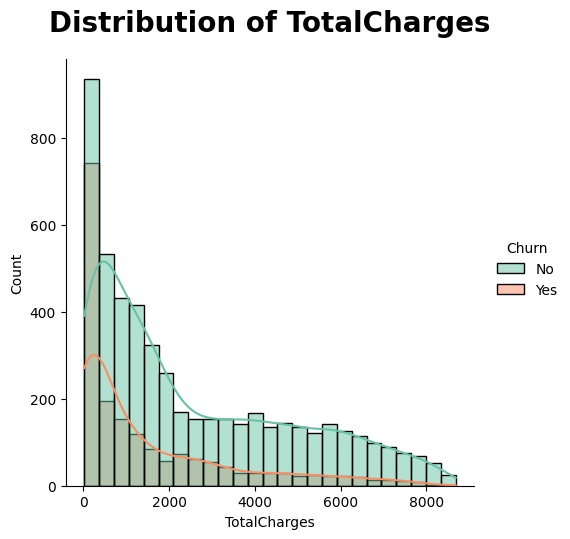

In [23]:
# Distribution of TotalCharges
DataVisualization.distribution(df, 'TotalCharges')

<Figure size 1000x500 with 0 Axes>

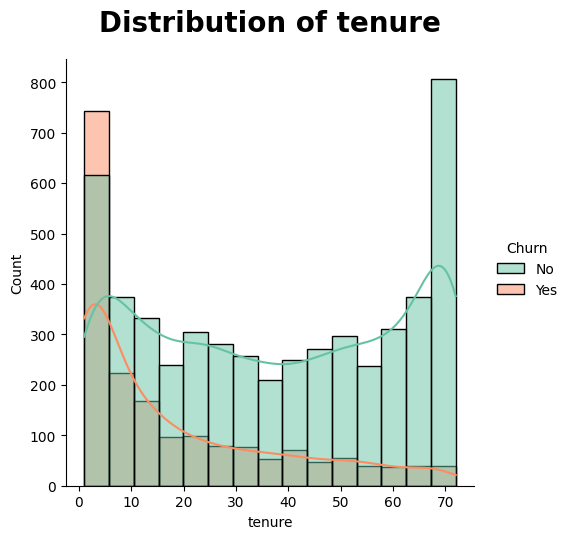

In [24]:
# Distribution of tenure
DataVisualization.distribution(df, 'tenure')

In [25]:
# Data Encoding
df = LabelEncoderHelper.label_encode(df)

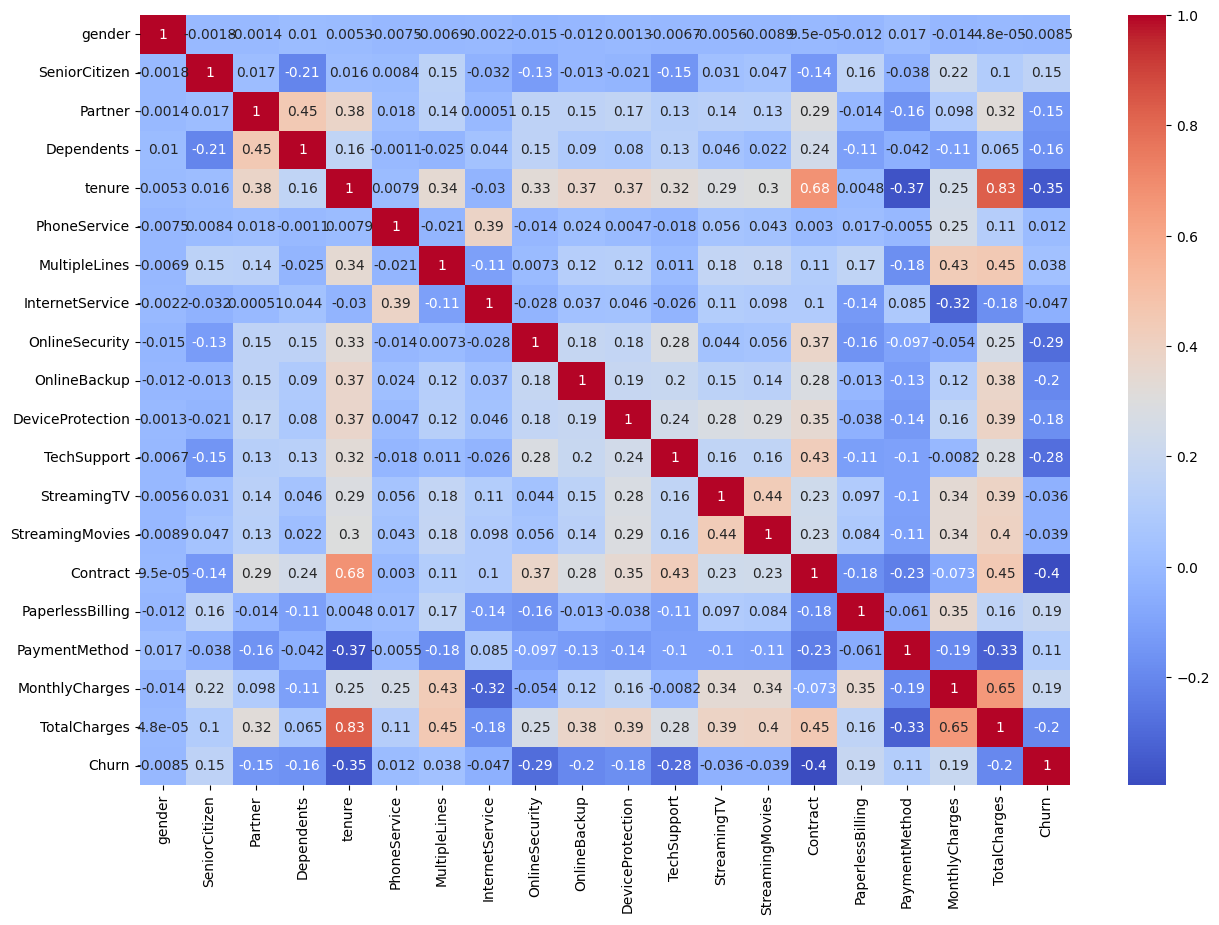

In [26]:
# Correlation
df.drop('customerID', axis=1, inplace=True)
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [27]:
# Removing tenure as it has a high correlation with TotalCharges
df.drop('tenure', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   PhoneService      7032 non-null   int64  
 5   MultipleLines     7032 non-null   int64  
 6   InternetService   7032 non-null   int64  
 7   OnlineSecurity    7032 non-null   int64  
 8   OnlineBackup      7032 non-null   int64  
 9   DeviceProtection  7032 non-null   int64  
 10  TechSupport       7032 non-null   int64  
 11  StreamingTV       7032 non-null   int64  
 12  StreamingMovies   7032 non-null   int64  
 13  Contract          7032 non-null   int64  
 14  PaperlessBilling  7032 non-null   int64  
 15  PaymentMethod     7032 non-null   int64  
 16  MonthlyCharges    7032 non-null   float64
 17  

# Feature Encoding & Scaling
This section encodes categorical variables, removes irrelevant features, performs correlation analysis,
and scales the features to prepare the data for modeling.


     gender  SeniorCitizen   Partner  Dependents  PhoneService  MultipleLines  \
0 -1.009430      -0.440327  1.035617   -0.652305     -3.056334       0.062666   
1  0.990658      -0.440327 -0.965608   -0.652305      0.327189      -0.991564   
2  0.990658      -0.440327 -0.965608   -0.652305      0.327189      -0.991564   
3  0.990658      -0.440327 -0.965608   -0.652305     -3.056334       0.062666   
4 -1.009430      -0.440327 -0.965608   -0.652305      0.327189      -0.991564   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0        -1.183614       -0.917837      1.242875         -1.026988   
1        -1.183614        1.408012     -1.028998          1.245441   
2        -1.183614        1.408012      1.242875         -1.026988   
3        -1.183614        1.408012     -1.028998          1.245441   
4         0.172835       -0.917837     -1.028998         -1.026988   

   TechSupport  StreamingTV  StreamingMovies  Contract  PaperlessBilling  \
0    -0.924267  

<Figure size 1000x500 with 0 Axes>

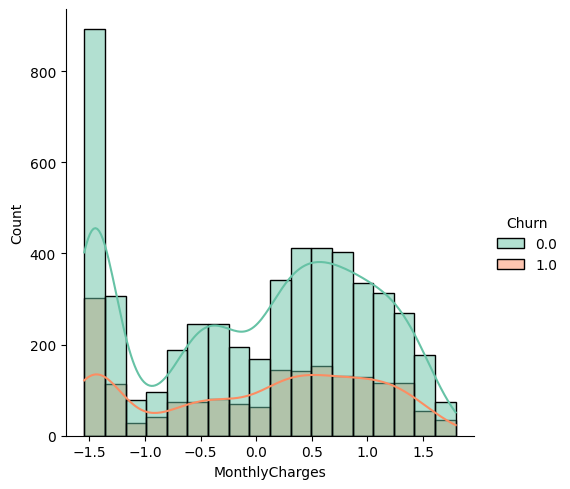

In [28]:
# Scaling
X_scaled, y = StandardScalerHelper.scale(df, 'Churn')
print(X_scaled.head())
y.value_counts()

# Distribution of MonthlyCharges - check if scaling is ok
plt.figure(figsize=(10, 5))
sns.displot(data=X_scaled, x='MonthlyCharges', hue=y, kde=True, palette="Set2")
plt.show()

# Model Creation, Training, and Evaluation
Here, we define multiple machine learning models, perform K-Fold cross-validation for evaluation,
and analyze performance metrics such as accuracy and confusion matrix.


In [29]:
# Data Modeling
multiple_models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', C=1, solver='lbfgs'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=50),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42),
    "SVC": SVC(class_weight='balanced',C=0.1,gamma='auto',kernel='rbf'),
}

process_data = DataProcessing(multiple_models)
model_results = process_data.KFold_cross_validation(X_scaled, y)
# Display Results - I did not visualize the confusion matrix because it's taking to much space
for result in model_results:
    print(f"Model: {result['Model Name']}")
    print(f"Accuracy: {result['Accuracy']:.2f}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}\n")

Model: Logistic Regression
Accuracy: 0.74
Confusion Matrix:
[[744 288]
 [ 75 298]]

Model: Random Forest
Accuracy: 0.79
Confusion Matrix:
[[931 101]
 [199 174]]

Model: Gradient Boosting
Accuracy: 0.80
Confusion Matrix:
[[935  97]
 [180 193]]

Model: XGBoost
Accuracy: 0.79
Confusion Matrix:
[[916 116]
 [180 193]]

Model: AdaBoostClassifier
Accuracy: 0.80
Confusion Matrix:
[[923 108]
 [167 206]]

Model: SVC
Accuracy: 0.73
Confusion Matrix:
[[726 306]
 [ 75 298]]



# Model Stacking
Stack multiple base models to generate meta-features and train a meta-model to enhance predictive performance.


Applying model stacking...
Stacking Model Accuracy: 0.9068941009239516


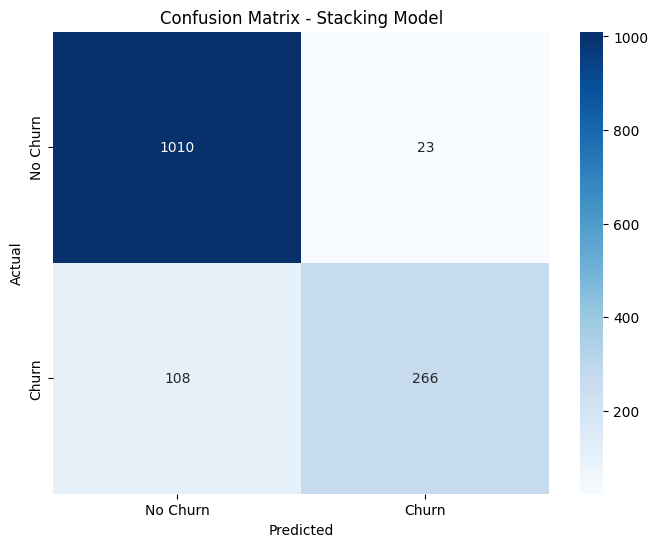

In [30]:
# Taking it further - Stacking - I want to know if stacking models will result to a better classification

base_models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', C=1, solver='lbfgs'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=50),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate= 0.05, max_depth= 3, n_estimators= 50),
    "XGBoost": XGBClassifier(),
    "SVC": SVC(class_weight='balanced', C=0.1, gamma='auto', kernel='rbf'),
}

# Meta models options
#SVC(class_weight='balanced', C=0.1, gamma='auto', kernel='rbf')
#GradientBoostingClassifier(learning_rate= 0.05, max_depth= 3, n_estimators= 50)
#SVC(class_weight='balanced', C=0.1, gamma='auto', kernel='rbf')
#LogisticRegression(class_weight='balanced')#GradientBoostingClassifier()
#XGBClassifier()
meta_model = GradientBoostingClassifier(learning_rate= 0.05, max_depth= 3, n_estimators= 50)

print("Applying model stacking...")
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
stacking_model = StackingModel(base_models=base_models, meta_model=meta_model)
stacked_predictions  = stacking_model.stack(X_scaled, y, X_test)
cm = confusion_matrix(y_test, stacked_predictions)

print("Stacking Model Accuracy:", accuracy_score(y_test, stacked_predictions))

# And it did resulted to a better prediction
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacking Model")
plt.show()